In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
import anndata
import scanpy as sc
import torch
from torch import nn
from scfoundation import load

In [2]:
class SlideData():
    def __init__(self, data_path, slide, pad_value, pad_token):
        self.data_path = data_path
        self.slide = slide
        self.pad_value = pad_value
        self.pad_token = pad_token
        self.load_data()

    def load_data(self):
        adata = sc.read_h5ad(f'{self.data_path}/{self.slide}_Visium_deconv.h5ad')
        
        scfoundation_gene_df = pd.read_csv(f'{tokenizer_dir}/scfoundation_gene_df.csv')
        scfoundation_gene_df.set_index('gene_ids', inplace=True)
        total_gene_num = adata.shape[1]
        adata = adata[:, adata.var_names.isin(scfoundation_gene_df.index)]
        adata.var['gene_name'] = scfoundation_gene_df.loc[adata.var_names, 'gene_symbols'].values
        seleted_gene_num = adata.shape[1]

        print(
            f"match {seleted_gene_num}/{total_gene_num} genes "
            f"in vocabulary of size 19264."
        )

        for celltype in adata.layers.keys():
            adata.X = adata.layers[celltype]
            sc.pp.normalize_total(adata, target_sum=1e4)
            sc.pp.log1p(adata)
            adata.uns.pop('log1p')
            adata.layers[celltype] = adata.X

        celltype_proportion = adata.obsm['q05_cell_abundance_w_sf']
        celltype_proportion.rename(columns=lambda x: x[23:], inplace=True)
        celltype_proportion = celltype_proportion.div(celltype_proportion.sum(axis=1), axis=0)
        celltype_proportion[celltype_proportion < 0.05] = 0
        celltype_proportion = celltype_proportion.div(celltype_proportion.sum(axis=1), axis=0)

        self.adata = adata
        self.celltype_proportion = celltype_proportion

    def get_sc_data(self):
        barcode_list = []
        gexpr_feature = []
        celltypes_labels = []
        for i in range(self.adata.shape[0]):
            barcode = self.adata.obs.index[i]
            ct_prop = self.celltype_proportion.iloc[i][self.celltype_proportion.iloc[i]>0]
            cell_num = 0
            for ct in ct_prop.index:
                celltypes_labels.append(ct)
                cell_num += 1
                barcode_list.append(f'{barcode}_{cell_num}')
                gexpr_feature.append(self.adata.layers[ct][i].A)
        gexpr_feature = np.concatenate(gexpr_feature)

        adata_sc = anndata.AnnData(X=gexpr_feature, obs=pd.DataFrame({'celltype': celltypes_labels}, index=barcode_list), var=pd.DataFrame({'gene_name': self.adata.var['gene_name'].values}, index=self.adata.var_names.values), obsm=None)
        self.adata = adata_sc

    def prepare_data(self):
        gene_list_df = pd.read_csv(f'{tokenizer_dir}/OS_scRNA_gene_index.19264.tsv', header=0, delimiter='\t')
        gene_list = list(gene_list_df['gene_name'])
        gene_list_df.set_index('gene_name', inplace=True)

        gexpr_feature = self.adata.X
        idx = self.adata.obs_names.tolist()
        col = self.adata.var.gene_name.tolist()
        gexpr_feature = pd.DataFrame(gexpr_feature, index=idx, columns=col)
        gexpr_feature, _ = load.main_gene_selection(gexpr_feature, gene_list)
        S = gexpr_feature.sum(1)
        T = S
        TS = np.concatenate([[np.log10(T)],[np.log10(S)]],axis=0).T
        data = np.concatenate([gexpr_feature,TS],axis=1)
        self.data = data

    def tokenize_data(self):
        data = torch.from_numpy(self.data).float()
        data_gene_ids = torch.arange(data.shape[1]).repeat(data.shape[0], 1)

        data_index = data != 0
        gene_values, gene_padding = load.gatherData(data, data_index, self.pad_value)
        gene_ids, _ = load.gatherData(data_gene_ids, data_index, self.pad_token)
        data = {'values': gene_values, 'padding': gene_padding, 'gene_ids': gene_ids}

        return data

In [3]:
class scF_Ccl(nn.Module):
    def __init__(
            self,
            scf_token_emb,
            scf_pos_emb,
            scf_encoder,
    ):
        super(scF_Ccl, self).__init__()

        # encoder
        self.token_emb = scf_token_emb
        self.pos_emb = scf_pos_emb
        self.encoder = scf_encoder

    def forward(self, gene_values, padding_label, gene_ids):

        x = self.token_emb(torch.unsqueeze(gene_values, 2), output_weight = 0)

        position_emb = self.pos_emb(gene_ids)
        x += position_emb
        x = self.encoder(x, padding_mask=padding_label)
        geneembmerge = torch.cat([torch.max(x[k][~padding_label[k]], dim=0)[0].unsqueeze(0) for k in range(x.size(0))])
        # geneembmerge, _ = torch.max(x, dim=1)

        return geneembmerge

In [4]:
def evaluate(model: nn.Module, data, batch_size) -> None:
    model.eval()

    gene_values = data['values']
    gene_padding = data['padding']
    gene_ids = data['gene_ids']

    cell_embeddings = []

    with torch.no_grad():
        for k in tqdm(range(0, len(gene_values), batch_size)):
            with torch.cuda.amp.autocast(enabled=amp):
                geneembmerge = model(gene_values[k:k+batch_size].to(device), 
                               gene_padding[k:k+batch_size].to(device), 
                               gene_ids[k:k+batch_size].to(device))
                
                cell_embeddings.append(geneembmerge.to('cpu'))
    
    return(torch.cat(cell_embeddings))

In [5]:
class scFoundation(nn.Module):
    def __init__(
            self,
            scf_token_emb,
            scf_pos_emb,
            scf_encoder,
            scf_decoder,
            scf_decoder_embed,
            scf_norm,
            scf_to_final,
    ):
        super(scFoundation, self).__init__()

        # encoder
        self.token_emb = scf_token_emb
        self.pos_emb = scf_pos_emb

        # ## DEBUG
        self.encoder = scf_encoder

        ##### decoder
        self.decoder = scf_decoder
        self.decoder_embed = scf_decoder_embed
        self.norm = scf_norm
        self.to_final = scf_to_final

    def forward(self, x, padding_label, encoder_position_gene_ids, encoder_labels, decoder_data,
                decoder_position_gene_ids, decoder_data_padding_labels, **kwargs):

        # token and positional embedding
        x = self.token_emb(torch.unsqueeze(x, 2), output_weight = 0)

        position_emb = self.pos_emb(encoder_position_gene_ids)
        x += position_emb
        x = self.encoder(x, padding_mask=padding_label)

        decoder_data = self.token_emb(torch.unsqueeze(decoder_data, 2))
        position_emb = self.pos_emb(decoder_position_gene_ids)
        batch_idx, gen_idx = (encoder_labels == True).nonzero(as_tuple=True)
        decoder_data[batch_idx, gen_idx] = x[~padding_label].to(decoder_data.dtype)

        decoder_data += position_emb

        decoder_data = self.decoder_embed(decoder_data)
        x = self.decoder(decoder_data, padding_mask=decoder_data_padding_labels)

        x = self.norm(x)
        # return x
        x = self.to_final(x)
        return x.squeeze(2)

In [6]:
model_type = 'pretrained' # 'fine-tuned'
# model_file = 'model_human_myocardial_infarction.ckpt'

if model_type == 'pretrained':
    pretrainmodel, pretrainconfig = load.load_model_frommmf('scfoundation/models/models.ckpt')
elif model_type == 'fine-tuned':
    pretrainmodel = torch.load(f'scfoundation/fine-tuning/{model_file}', map_location='cpu')
    pretrainmodel = pretrainmodel.module

In [7]:
model = scF_Ccl(pretrainmodel.token_emb,
            pretrainmodel.pos_emb,
            pretrainmodel.encoder)

In [8]:
device = torch.device("cuda:2")

model = nn.DataParallel(model, device_ids = [2, 3, 0])
model.to(device)

DataParallel(
  (module): scF_Ccl(
    (token_emb): AutoDiscretizationEmbedding2(
      (mlp): Linear(in_features=1, out_features=100, bias=True)
      (mlp2): Linear(in_features=100, out_features=100, bias=True)
      (LeakyReLU): LeakyReLU(negative_slope=0.1)
      (Softmax): Softmax(dim=-1)
      (emb): Embedding(100, 768)
      (emb_mask): Embedding(1, 768)
      (emb_pad): Embedding(1, 768)
    )
    (pos_emb): Embedding(19267, 768)
    (encoder): pytorchTransformerModule(
      (transformer_encoder): ModuleList(
        (0-11): 12 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)

In [ ]:
pad_token = 19266
pad_value = 103

tokenizer_dir = '../stformer/tokenizer/'

In [ ]:
dataset = 'human_myocardial_infarction_dataset'
data_path = f'../data/{dataset}/'
slide = '10X0020'
batch_size = 48
amp = True

slideData = SlideData(data_path, slide, pad_value, pad_token)
slideData.get_sc_data()
slideData.prepare_data()
data = slideData.tokenize_data()

match 10635/11502 genes in vocabulary of size 19264.


In [11]:
cell_embeddings = evaluate(model,data, batch_size)
slideData.adata.obsm['cell_embeddings'] = cell_embeddings.numpy()

100%|██████████| 328/328 [09:37<00:00,  1.76s/it]


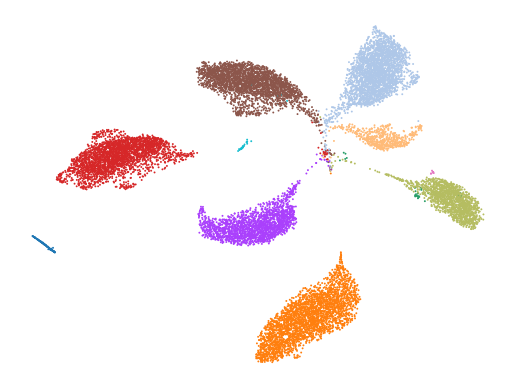

In [12]:
import matplotlib.pyplot as plt

sc.pp.neighbors(slideData.adata, use_rep='cell_embeddings')
sc.tl.umap(slideData.adata)
sc.pl.umap(slideData.adata,
           title='',
           frameon=False,
           legend_loc='',
           legend_fontsize='xx-small',
           save=f"_scFoundation_{slide}.pdf",
           color='celltype')

In [13]:
import scib

slideData.adata.obs['batch'] = [1]*slideData.adata.shape[0]

results = scib.metrics.metrics(
        slideData.adata,
        adata_int=slideData.adata,
        label_key='celltype',
        batch_key='batch',
        embed='cell_embeddings',
        silhouette_=True,
        nmi_=True,
        ari_=True,
    )

result_dict = results[0].to_dict()

/home/shcao/miniconda3/lib/python3.11/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/shcao/miniconda3/lib/python3.11/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/shcao/miniconda3/lib/python3.11/site-packages/seaborn/cm.py:1582: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  mpl_cm.register_cmap(_name, _cmap)
/home/shcao/miniconda3/lib/python3.11/site-packages/seaborn/cm.py:1583: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  mpl_cm.register

NMI...
ARI...
Silhouette score...


In [14]:
result_dict
# ACH005: NMI 0.938, ARI 0.944
# 10X001: NMI 0.933, ARI 0.933
# ACH002: NMI 0.975, ARI 0.9908
# 10X009: NMI 0.954, ARI 0.978
# ACH006: NMI 0.887, ARI 0.894
# ACH007: NMI 0.610, ARI 0.432
# 10X0017: NMI 0.846, ARI 0.731
# 10X0025: NMI 0.987, ARI 0.994
# 10X0020: NMI 0.984, ARI 0.992

{'NMI_cluster/label': 0.9844209916962835,
 'ARI_cluster/label': 0.9918434652883849,
 'ASW_label': 0.6433477401733398,
 'ASW_label/batch': nan,
 'PCR_batch': nan,
 'cell_cycle_conservation': nan,
 'isolated_label_F1': nan,
 'isolated_label_silhouette': nan,
 'graph_conn': nan,
 'kBET': nan,
 'iLISI': nan,
 'cLISI': nan,
 'hvg_overlap': nan,
 'trajectory': nan}